In [0]:
import numpy as np
import keras
from keras import backend as K
from keras.optimizers import Adam, SGD

from keras.layers import Flatten, Dropout, BatchNormalization, Reshape, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import pandas as pd

from keras.preprocessing import image

from sklearn.model_selection import train_test_split

import os
import shutil

import matplotlib.image as mpimg

Using TensorFlow backend.


In [0]:
!unzip -q ad-2d.zip

In [0]:
!unzip -q cn-2d.zip

In [0]:
!mkdir training && mkdir validation

In [0]:
!mkdir training/ad && mkdir validation/ad

In [0]:
!mkdir training/cn && mkdir validation/cn

In [0]:
!mkdir ad && mkdir cn

In [0]:
ad_main_folder = 'ad-2d'
cn_main_folder = 'cn-2d'

for ad_folder in os.listdir(ad_main_folder):
  images_name_path = f'{ad_main_folder}/{ad_folder}'
  images = os.listdir(images_name_path)
  
  for image_path in images:
    image_url = f'{images_name_path}/{image_path}'
    shutil.move(image_url, 'ad')
    
for cn_folder in os.listdir(cn_main_folder):
  images_name_path = f'{cn_main_folder}/{cn_folder}'
  images = os.listdir(images_name_path)
  
  for image_path in images:
    image_url = f'{images_name_path}/{image_path}'
    shutil.move(image_url, 'cn')

In [0]:
class_size = len(os.listdir('ad'))
validation_size = 0.20
validation_class_size = int(class_size * 0.20)

In [0]:
class_size, validation_class_size

(39753, 7950)

In [0]:
training_ad_folder_name = "training/ad"
training_cn_folder_name = "training/cn"

validation_ad_folder_name = "validation/ad"
validation_cn_folder_name = "validation/cn"

ad_folder = os.listdir("ad")
cn_folder = os.listdir("cn")

for image_name in ad_folder[:validation_class_size]:
  image_url = f'ad/{image_name}'
  shutil.move(image_url, validation_ad_folder_name)
  
for image_name in ad_folder[validation_class_size:]:
  image_url = f'ad/{image_name}'
  shutil.move(image_url, training_ad_folder_name)
  
for image_name in cn_folder[:validation_class_size]:
  image_url = f'cn/{image_name}'
  shutil.move(image_url, validation_cn_folder_name)
  
for image_name in cn_folder[validation_class_size:]:
  image_url = f'cn/{image_name}'
  shutil.move(image_url, training_cn_folder_name)

In [0]:
batch_size = 128
img_size = 128
input_img_size = (128, 128, 1)
num_classes = 2

In [0]:
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest").flow_from_directory(
    "training",
    target_size=(img_size, img_size),
    color_mode="grayscale",
	  shuffle=True,
    batch_size=batch_size)


val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input).flow_from_directory(
    "validation",
    target_size=(img_size, img_size),
    color_mode="grayscale",
	  shuffle=False,
    batch_size=batch_size)

Found 63646 images belonging to 2 classes.
Found 15900 images belonging to 2 classes.


In [0]:
training_folder_size = 63646
validation_folder_size = 15900

In [0]:
train_steps = training_folder_size // batch_size
val_steps = validation_folder_size // batch_size

In [0]:
train_steps, val_steps

(497, 124)

In [0]:
def create_model():
  input_tensor = Input(shape=input_img_size)
  
  mobile_model = MobileNetV2(
       weights=None,
       input_tensor=input_tensor,
       input_shape=input_img_size,
       alpha=1.5,
       include_top=False)
  
  for layer in mobile_model.layers:
    layer.trainable = True
  
  mobile_model_output = mobile_model.output
  classification_layer = Flatten()(mobile_model_output)
  classification_layer = Dense(256, activation='relu')(classification_layer)
  classification_layer = Dropout(0.5)(classification_layer)
  predictions = Dense(activation="softmax", units=num_classes)(classification_layer)

  model = Model(inputs=input_tensor, outputs=predictions)
  
  return model

In [0]:
learning_rate = 3e-4
epochs = 100

In [0]:
def polynomial_decay(epoch):
	power = 1.0
 
	alpha = learning_rate * (1 - (epoch / float(epochs))) ** power
	return alpha

In [0]:
weights_name = "epoch={epoch:02d}|accuracy={val_acc:.4f}.h5"

checkpoint = ModelCheckpoint(weights_name, monitor="val_acc", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="max", period=1)

lr_decay = LearningRateScheduler(polynomial_decay)

optimizer = SGD(lr=learning_rate, momentum=0.9)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model = create_model()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
trained_model = model.fit_generator(train_generator,
                        epochs=epochs,
                        steps_per_epoch=train_steps,
                        callbacks=[checkpoint, lr_decay],
                        validation_data=val_generator,
                        validation_steps=val_steps,
                        verbose=1)

Epoch 1/100
497/497 [==============================] - 379s 762ms/step - loss: 0.6978 - acc: 0.5550 - val_loss: 0.7353 - val_acc: 0.5232

Epoch 00001: val_acc improved from -inf to 0.52321, saving model to epoch=01|accuracy=0.5232.h5
Epoch 2/100
497/497 [==============================] - 362s 727ms/step - loss: 0.6696 - acc: 0.5923 - val_loss: 0.6950 - val_acc: 0.5642

Epoch 00002: val_acc improved from 0.52321 to 0.56423, saving model to epoch=02|accuracy=0.5642.h5
Epoch 3/100
497/497 [==============================] - 361s 727ms/step - loss: 0.6555 - acc: 0.6136 - val_loss: 0.8413 - val_acc: 0.5605

Epoch 00003: val_acc did not improve from 0.56423
Epoch 4/100
497/497 [==============================] - 362s 728ms/step - loss: 0.6301 - acc: 0.6454 - val_loss: 0.9799 - val_acc: 0.5241

Epoch 00004: val_acc did not improve from 0.56423
Epoch 5/100
497/497 [==============================] - 361s 727ms/step - loss: 0.5921 - acc: 0.6802 - val_loss: 1.4098 - val_acc: 0.5183

Epoch 00005: va

In [0]:
def plot_validation_training(metric, trained_model):
  validation_metric = trained_model.history[f'val_{metric}']
  training_metric = trained_model.history[metric]
  epochs = range(len(training_metric))
  plt.plot(epochs, training_metric, 'b', label=f'Training {metric}')
  plt.plot(epochs, validation_metric, 'r', label=f'Validation {metric}')
  plt.ylim(bottom=0)
  plt.xlabel('Epochs ', fontsize=16)
  plt.ylabel(metric, fontsize=16)
  loc = 'upper right' if metric == "loss" else 'lower right'
  plt.legend(loc=loc)
  plt.title(f'Training and validation {metric}', fontsize = 20)
  plt.show()

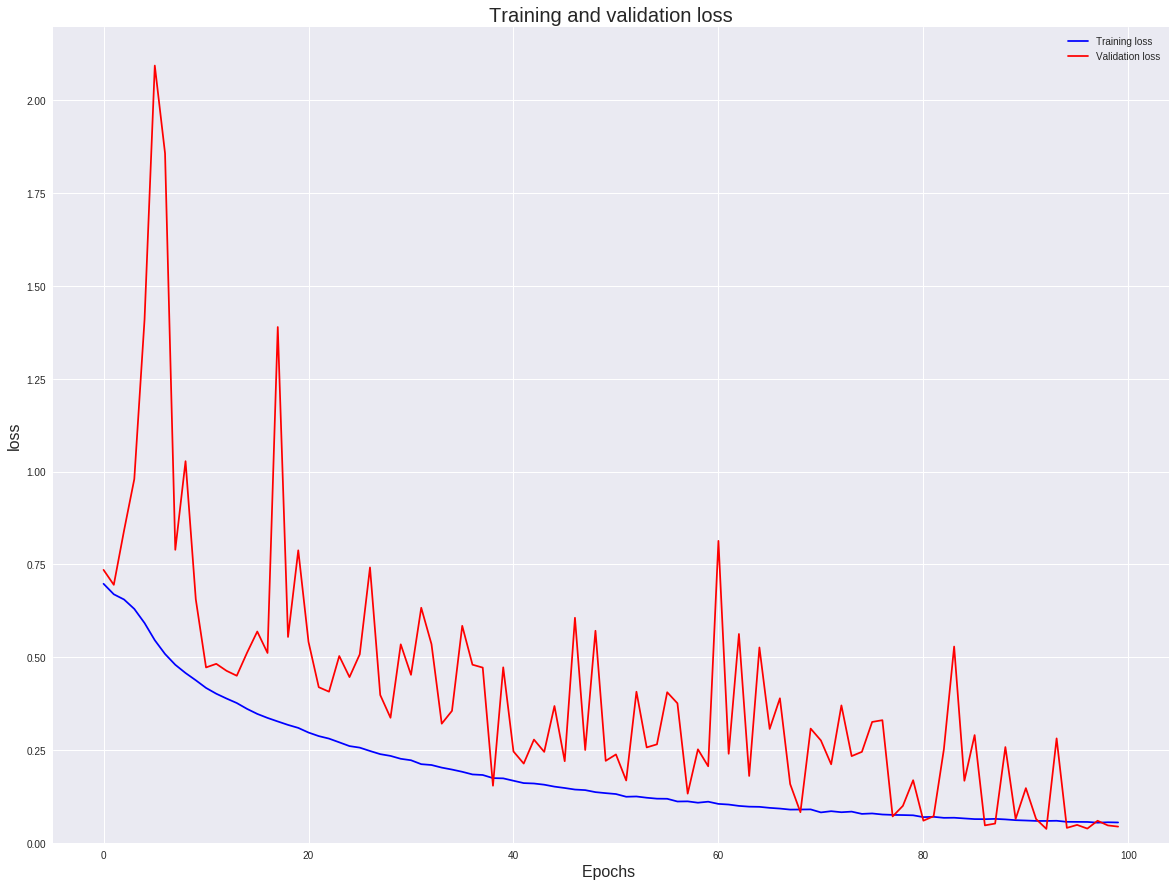

In [0]:
plot_validation_training("loss", trained_model)

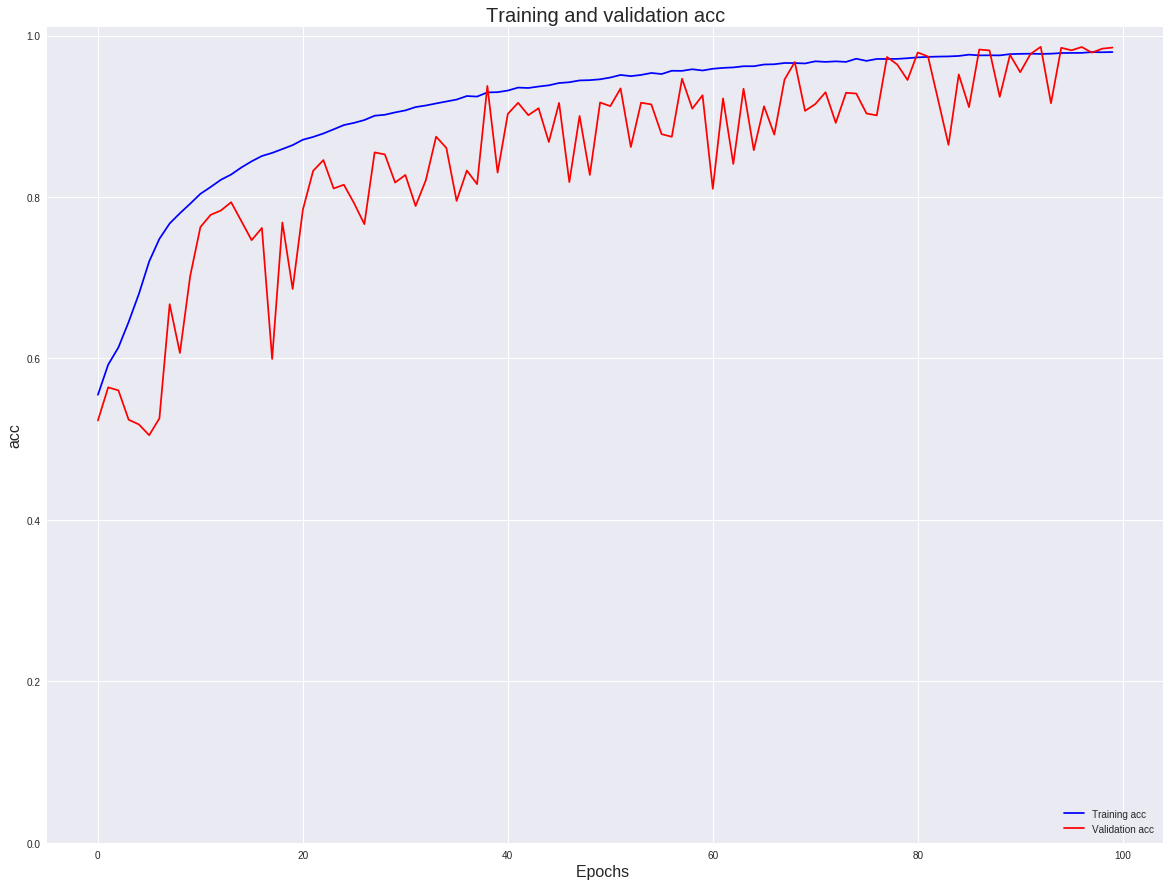

In [0]:
plot_validation_training("acc", trained_model)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
model.load_weights("epoch=93_accuracy=0.9861.h5")

In [0]:
val_generator.reset()

In [0]:
classes_predicted = model.predict_generator(val_generator, steps=val_steps, verbose=1)

124/124 [==============================] - 30s 238ms/step


In [0]:
len(classes_predicted)

15872

In [0]:
real_predicted_classes = np.argmax(classes_predicted, axis=1)

In [0]:
val_labels = val_generator.classes

In [0]:
len(val_labels)

15900

In [0]:
val_labels = val_labels[:15872]

In [0]:
len(val_labels), len(real_predicted_classes)

(15872, 15872)

In [0]:
val_generator.class_indices

{'ad': 0, 'cn': 1}

In [0]:
classes_names = ["ad", "cn"]

Confusion matrix, without normalization


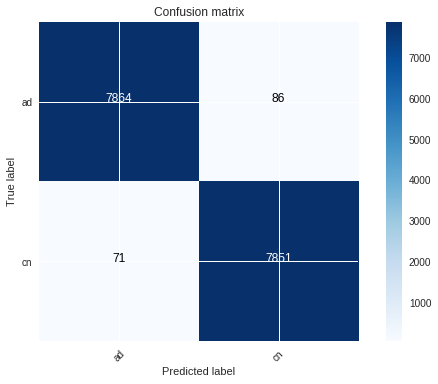

In [0]:
cm = confusion_matrix(val_labels, real_predicted_classes, labels=range(num_classes))
plot_confusion_matrix(cm, classes_names)

In [0]:
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print(f'sensitivity: {sensitivity}')

specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
print(f'specificity: {specificity}')

sensitivity: 0.9891823899371069
specificity: 0.9910376167634436


In [0]:
from sklearn.metrics import classification_report

In [0]:
report = classification_report(val_labels, real_predicted_classes, target_names=classes_names)
print(report)

              precision    recall  f1-score   support

          ad       0.99      0.99      0.99      7950
          cn       0.99      0.99      0.99      7922

   micro avg       0.99      0.99      0.99     15872
   macro avg       0.99      0.99      0.99     15872
weighted avg       0.99      0.99      0.99     15872



## Save model

In [0]:
model_json = model.to_json()
with open("ad.json", "w") as json_file:
    json_file.write(model_json)